In [ ]:
from math import sqrt
import numpy as np
import matplotlib.pyplot as plt
import pre_processing as pp
import csv
import pandas as pd
import tensorflow as tf

# Dataset ting

In [ ]:
pd.set_option('display.max_columns', None)
df = pd.read_csv('data/6-gon-correct-procrustes.csv')

df = df.iloc[:, :14]
dataset = df.drop(columns=['target_edge_length'])

training = dataset.sample(frac=0.85)
testing = dataset.drop(training.index)

train_features = training.iloc[:, :12]
train_labels = training.iloc[:, -1:]

test_features = testing.iloc[:, :12]
test_labels = testing.iloc[:, -1:]

# Model ting

In [31]:
import tensorflow as tf
from tensorflow.keras import layers
import os, datetime

model_path = "model/thesis-internal-node-count-6gon-lower-batch"
BATCH_SIZE = 512
EPOCHS = 5000
INITIAL_LEARNING_RATE = 1e-1

def model_setup():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(12,)),
        layers.BatchNormalization(),

        layers.Dense(48, activation='relu'),
        layers.BatchNormalization(),

        layers.Dense(48, activation='relu'),
        layers.BatchNormalization(),

        layers.Dense(1),
    ])
    return model

def train_model(model, model_epochs=EPOCHS, model_batch_size=BATCH_SIZE, learning_rate=INITIAL_LEARNING_RATE):
    # Callbacks
    # logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    # tensorboard = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
    checkpoint = tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', verbose=0, save_best_only=True, mode='min')
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=EPOCHS//5, min_delta=0.0001)

    # Learning rate scheduler
    decay_steps= 10_000
    lr_schedule = tf.keras.optimizers.schedules.PolynomialDecay(
        learning_rate, 
        decay_steps, 
        1e-2
        )

    # Initialize model
    model.compile(loss=tf.losses.MeanAbsoluteError(),
                optimizer=tf.optimizers.Adam(
                learning_rate=lr_schedule
            ),
            )

    # Train model and write progress to history (for graphing)
    history = model.fit(train_features,
                        train_labels,
                        epochs=model_epochs,
                        batch_size=model_batch_size,
                        validation_split=0.18,
                        verbose=2,
                        callbacks=[checkpoint, early_stopping],
                        )
    return history


# %load_ext tensorboard
# %tensorboard --logdir logs
model = model_setup()
history = train_model(model)

# ======================
#       EVALUATION
# ======================
train_acc = model.evaluate(
    train_features, train_labels, verbose=0)
test_acc = model.evaluate(
    test_features, test_labels, verbose=0)
print('Training data loss: %.3f, Test data loss: %.3f' %
        (train_acc, test_acc))      


583
Epoch 1392/5000
14/14 - 0s - loss: 0.3642 - val_loss: 0.4599
Epoch 1393/5000
14/14 - 0s - loss: 0.3658 - val_loss: 0.4626
Epoch 1394/5000
14/14 - 0s - loss: 0.3664 - val_loss: 0.4640
Epoch 1395/5000
14/14 - 0s - loss: 0.3633 - val_loss: 0.4658
Epoch 1396/5000
14/14 - 0s - loss: 0.3612 - val_loss: 0.4610
Epoch 1397/5000
14/14 - 0s - loss: 0.3671 - val_loss: 0.4589
Epoch 1398/5000
14/14 - 0s - loss: 0.3618 - val_loss: 0.4650
Epoch 1399/5000
14/14 - 0s - loss: 0.3649 - val_loss: 0.4691
Epoch 1400/5000
14/14 - 0s - loss: 0.3657 - val_loss: 0.4665
Epoch 1401/5000
14/14 - 0s - loss: 0.3677 - val_loss: 0.4623
Epoch 1402/5000
14/14 - 0s - loss: 0.3663 - val_loss: 0.4590
Epoch 1403/5000
14/14 - 0s - loss: 0.3637 - val_loss: 0.4608
Epoch 1404/5000
14/14 - 0s - loss: 0.3640 - val_loss: 0.4627
Epoch 1405/5000
14/14 - 0s - loss: 0.3643 - val_loss: 0.4588
Epoch 1406/5000
14/14 - 0s - loss: 0.3644 - val_loss: 0.4604
Epoch 1407/5000
14/14 - 0s - loss: 0.3658 - val_loss: 0.4579
Epoch 1408/5000
14/1

(0.33, 0.6)

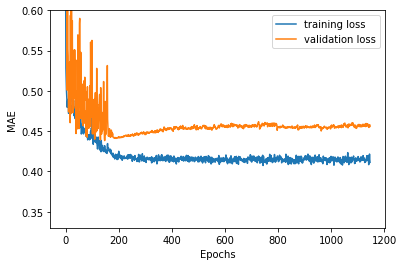

In [27]:
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.ylim(0.33, 0.6)

In [26]:
# ======================
#  EVALUATE SAVED MODEL 
# ======================

saved_model = tf.keras.models.load_model(model_path)

train_acc = saved_model.evaluate(
    train_features, train_labels, verbose=0)
test_acc = saved_model.evaluate(
    test_features, test_labels, verbose=0)
print('Training data loss: %.3f, Test data loss: %.3f' %
        (train_acc, test_acc))

Training data loss: 0.413, Test data loss: 0.457


In [33]:


thesis_model = tf.keras.models.load_model('model/thesis-internal-node-count-6gon')
thesis_model.summary()

train_acc = thesis_model.evaluate(
    train_features, train_labels, verbose=0)
test_acc = thesis_model.evaluate(
    test_features, test_labels, verbose=0)
print('Training data loss: %.3f, Test data loss: %.3f' %
        (train_acc, test_acc))

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_21 (Batc (None, 12)                48        
_________________________________________________________________
dense_21 (Dense)             (None, 24)                312       
_________________________________________________________________
batch_normalization_22 (Batc (None, 24)                96        
_________________________________________________________________
dense_22 (Dense)             (None, 24)                600       
_________________________________________________________________
batch_normalization_23 (Batc (None, 24)                96        
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 25        
Total params: 1,177
Trainable params: 1,057
Non-trainable params: 120
__________________________________________________